Author: Dominique Grimes


Date: June 30, 2024


Project: Bank Client Segmentation with KMeans++


In [1]:
# load libraries
from sklearn.cluster import KMeans,DBSCAN
import pandas as pd
from time import time
import numpy as np
import warnings
from datetime import datetime,date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import random
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Supress warnings
warnings.filterwarnings("ignore")

In [3]:
# load data into df
df = pd.read_csv('bank_transactions.csv')

In [4]:
# view data
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [5]:
# view row and column counts
df.shape

(1048567, 9)

In [6]:
# view data type
df.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

# Data Cleansing

## Observe and Manage Null Values

In [7]:
# Check for null values
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [8]:
# Create new DF with null rows deleted
df2 = df.dropna()

In [9]:
# Verify no null values
df2.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [10]:
# Observe shape of the new df
df2.shape

(1041614, 9)

Lost approx 7,000 rows out 1M+ rows (0.7%)

## Observe Value Counts & Transform Data

### Transaction Date

In [11]:
# Transform TrnasactionDate to datetime
df2['TransactionDate'] = pd.to_datetime(df2['TransactionDate'])

In [12]:
df2['TransactionDate'].value_counts().sort_index()

2016-01-08    20277
2016-01-09    22179
2016-02-08    20787
2016-02-09    22718
2016-03-08    20446
2016-03-09    26292
2016-04-08    20535
2016-04-09    26420
2016-05-08    20949
2016-05-09    21116
2016-06-08    26416
2016-06-09    19510
2016-07-08    27084
2016-07-09    20999
2016-08-08    20883
2016-08-09    21648
2016-08-13    26738
2016-08-14    25407
2016-08-15    24020
2016-08-16    20278
2016-08-17    20960
2016-08-18    19338
2016-08-19    18559
2016-08-20    21188
2016-08-21    22833
2016-08-22    18441
2016-08-23    17239
2016-08-24    17893
2016-08-25    18424
2016-08-26    17615
2016-08-27    21349
2016-08-28    20944
2016-08-29    16700
2016-08-30    17273
2016-08-31    19586
2016-09-08    21673
2016-09-09    21444
2016-09-13    20506
2016-09-14    19845
2016-09-15    19610
2016-09-18    14622
2016-09-22     6925
2016-09-23     3460
2016-09-25     8127
2016-09-26    12376
2016-09-27     7401
2016-09-30     1935
2016-10-08    21457
2016-10-09    25628
2016-10-16        3


In [13]:
# Create three categorical features from date - month, day, dayofweek
df2['TransactionMonth'] = df2['TransactionDate'].dt.month
df2['TransactionDay'] = df2['TransactionDate'].dt.day
df2['TransactionDOW'] = df2['TransactionDate'].dt.dayofweek

In [14]:
# Verify columns were created
df2.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,2,8,0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,2,8,0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2016-02-08,142712,459.0,2,8,0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,2,8,0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,2,8,0


### Customer Location

In [15]:
df2['CustLocation'].value_counts()

MUMBAI                            101997
NEW DELHI                          84143
BANGALORE                          81330
GURGAON                            73594
DELHI                              70549
                                   ...  
DISTRICT PURI                          1
DHAKOLA                                1
KANDESHWAR STATION NAVI MUMBAI         1
HOSHIAR PUR                            1
IMPERIA THANE WEST                     1
Name: CustLocation, Length: 9275, dtype: int64

In [16]:
le = preprocessing.LabelEncoder()
df2['CustLocation']= le.fit_transform(df2['CustLocation'])
df2.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW
0,T1,C5841053,10/1/94,F,3557,17819.05,2016-02-08,143207,25.0,2,8,0
1,T2,C2142763,4/4/57,M,3618,2270.69,2016-02-08,141858,27999.0,2,8,0
2,T3,C4417068,26/11/96,F,5219,17874.44,2016-02-08,142712,459.0,2,8,0
3,T4,C5342380,14/9/73,F,5219,866503.21,2016-02-08,142714,2060.0,2,8,0
4,T5,C9031234,24/3/88,F,5606,6714.43,2016-02-08,181156,1762.5,2,8,0


### Transaction ID

In [17]:
# View if transaction ID is unique
df2['TransactionID'].is_unique

True

In [18]:
# Since this is unique value and df has index, drop this column
df2 = df2.drop('TransactionID', axis=1)

In [19]:
# Verify column was dropped
df2.head()

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW
0,C5841053,10/1/94,F,3557,17819.05,2016-02-08,143207,25.0,2,8,0
1,C2142763,4/4/57,M,3618,2270.69,2016-02-08,141858,27999.0,2,8,0
2,C4417068,26/11/96,F,5219,17874.44,2016-02-08,142712,459.0,2,8,0
3,C5342380,14/9/73,F,5219,866503.21,2016-02-08,142714,2060.0,2,8,0
4,C9031234,24/3/88,F,5606,6714.43,2016-02-08,181156,1762.5,2,8,0


### CustGender

In [20]:
df2['CustGender'].value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

In [21]:
# Drop value T since only 1. This is an outlier.
df2 = df2[df2.CustGender != "T"]

In [22]:
# Verify  
df2['CustGender'].value_counts()

M    760978
F    280635
Name: CustGender, dtype: int64

In [23]:
# converting to binary data
df_gender = pd.get_dummies(df2["CustGender"])
df_gender.head()

,F,M
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [24]:
df3 = pd.concat((df_gender, df2), axis=1)
df3 = df3.drop(["CustGender"], axis=1)
df3 = df3.drop(["F"], axis=1)

In [25]:
df3 = df3.rename(columns={"M": "Gender"})

In [26]:
df3.head()

,Gender,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW
0,0,C5841053,10/1/94,3557,17819.05,2016-02-08,143207,25.0,2,8,0
1,1,C2142763,4/4/57,3618,2270.69,2016-02-08,141858,27999.0,2,8,0
2,0,C4417068,26/11/96,5219,17874.44,2016-02-08,142712,459.0,2,8,0
3,0,C5342380,14/9/73,5219,866503.21,2016-02-08,142714,2060.0,2,8,0
4,0,C9031234,24/3/88,5606,6714.43,2016-02-08,181156,1762.5,2,8,0


### CustomerDOB to CustAge

In [27]:
# Transform Customer DOB to datetime
df3["CustomerDOB"] = pd.to_datetime(df3["CustomerDOB"])

In [28]:
# View df3
df3.head()

,Gender,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW
0,0,C5841053,1994-10-01,3557,17819.05,2016-02-08,143207,25.0,2,8,0
1,1,C2142763,2057-04-04,3618,2270.69,2016-02-08,141858,27999.0,2,8,0
2,0,C4417068,1996-11-26,5219,17874.44,2016-02-08,142712,459.0,2,8,0
3,0,C5342380,2073-09-14,5219,866503.21,2016-02-08,142714,2060.0,2,8,0
4,0,C9031234,1988-03-24,5606,6714.43,2016-02-08,181156,1762.5,2,8,0


In [29]:
# Add new column to calculate age of customer at the time of transaction
df3['CustAge'] =((df3['TransactionDate'] - df3['CustomerDOB'])/np.timedelta64(1, 'Y')).round(0)

In [30]:
# View new column age
df3.head()

,Gender,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW,CustAge
0,0,C5841053,1994-10-01,3557,17819.05,2016-02-08,143207,25.0,2,8,0,21.0
1,1,C2142763,2057-04-04,3618,2270.69,2016-02-08,141858,27999.0,2,8,0,-41.0
2,0,C4417068,1996-11-26,5219,17874.44,2016-02-08,142712,459.0,2,8,0,19.0
3,0,C5342380,2073-09-14,5219,866503.21,2016-02-08,142714,2060.0,2,8,0,-58.0
4,0,C9031234,1988-03-24,5606,6714.43,2016-02-08,181156,1762.5,2,8,0,28.0


In [31]:
# Drop DOB column
df3 = df3.drop('CustomerDOB', axis=1)

In [32]:
# Verify dropped column
df3.head(1)

,Gender,CustomerID,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW,CustAge
0,0,C5841053,3557,17819.05,2016-02-08,143207,25.0,2,8,0,21.0


In [33]:
# View max rows
pd.set_option("display.max_rows", None)

# View ages
df3['CustAge'].value_counts().sort_index()

-58.0       711
-57.0      8404
-56.0      8963
-55.0      7626
-54.0      7312
-53.0      5882
-52.0      5975
-51.0      4787
-50.0      4199
-49.0      3875
-48.0      3512
-47.0      3387
-46.0      3043
-45.0      2191
-44.0      2168
-43.0      2254
-42.0      1598
-41.0      1556
-40.0      1639
-39.0      1813
-38.0      1768
-37.0      1438
-36.0      1452
-35.0      1087
-34.0      1001
-33.0       857
-32.0       715
-31.0       727
-30.0       454
-29.0       417
-28.0       380
-27.0       350
-26.0       394
-25.0       286
-24.0       296
-23.0       176
-22.0       270
-21.0       151
-20.0       116
-19.0        96
-18.0        86
-17.0        65
-16.0        77
-15.0        82
-14.0        45
-13.0        59
-12.0        37
-11.0        44
-10.0        15
-9.0          2
-8.0          1
-7.0          7
-6.0          4
-5.0          2
-4.0         24
-3.0          5
-1.0          1
 0.0          3
 1.0         24
 2.0          7
 3.0         28
 4.0         29
 5.0    

In [34]:
# Drop rows that have an age less than 0
df4 = df3.drop(df3[df3['CustAge'] <= 0].index,axis = 0)

In [35]:
# Drop rows that have ages over 100
df5 = df4.drop(df4[df4['CustAge'] > 100].index,axis = 0)

In [36]:
# View ages in updated data frame
df5['CustAge'].value_counts().sort_index()

1.0        24
2.0         7
3.0        28
4.0        29
5.0         3
6.0        12
7.0        17
8.0        16
9.0        28
10.0       39
11.0       35
12.0       52
13.0       79
14.0       93
15.0      152
16.0      250
17.0      661
18.0     1916
19.0     6705
20.0    12438
21.0    20174
22.0    35166
23.0    51728
24.0    64813
25.0    71058
26.0    72567
27.0    69835
28.0    62738
29.0    59150
30.0    52913
31.0    46567
32.0    41347
33.0    36166
34.0    32845
35.0    27868
36.0    24897
37.0    22706
38.0    19555
39.0    17169
40.0    15094
41.0    12448
42.0    10487
43.0     1562
Name: CustAge, dtype: int64

## Drop columns not utilized

In [37]:
# Drop three columns
df5 = df5.drop(["CustomerID", "TransactionDate", "TransactionTime"], axis=1)

In [38]:
# Verify columns removed
df5.head()

,Gender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW,CustAge
0,0,3557,17819.05,25.0,2,8,0,21.0
2,0,5219,17874.44,459.0,2,8,0,19.0
4,0,5606,6714.43,1762.5,2,8,0,28.0
6,0,5219,973.46,566.0,2,8,0,24.0
7,1,5219,95075.54,148.0,2,8,0,34.0


# Exploritory Data Analysis

## Summary Statistics

In [39]:
column_names = ['Gender','CustLocation','CustAccountBalance','TransactionAmount (INR)','TransactionMonth','TransactionDay', 'TransactionDOW','CustAge']

In [40]:
df5[column_names].describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,891437.0,0.722902,0.447565,0.0,0.00,1.00,1.00,1.00
CustLocation,891437.0,4077.572227,2369.916350,0.0,2055.00,3961.00,5738.00,9274.00
CustAccountBalance,891437.0,79355.855848,376160.129439,0.0,4238.58,14652.92,46901.87,43165555.53
TransactionAmount (INR),891437.0,1284.402527,5432.465237,0.0,147.00,399.00,1008.63,1560034.99
TransactionMonth,891437.0,7.341831,2.640785,1.0,6.00,8.00,9.00,12.00
TransactionDay,891437.0,14.371821,7.274276,8.0,8.00,9.00,20.00,31.00
TransactionDOW,891437.0,2.998495,1.980414,0.0,1.00,3.00,5.00,6.00
CustAge,891437.0,28.949356,5.355379,1.0,25.00,28.00,32.00,43.00


## Univariate Analysis

### Boxplots

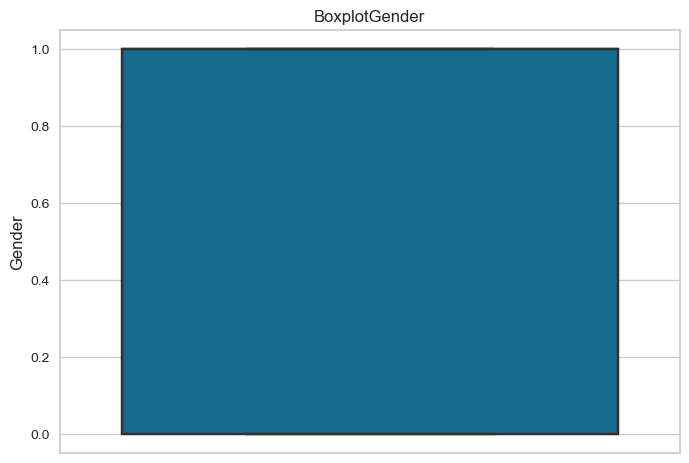

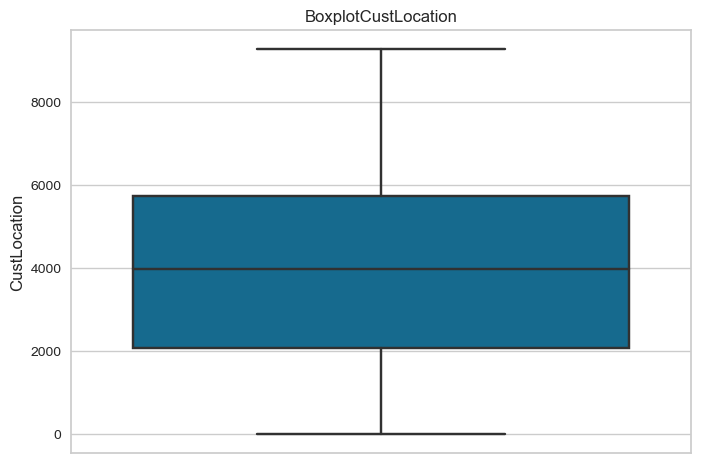

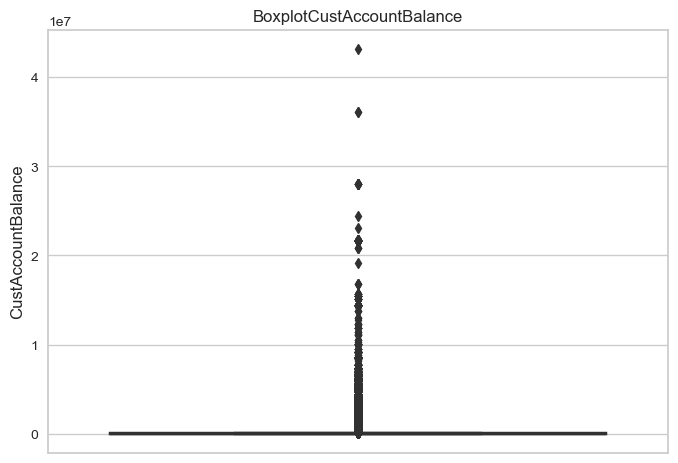

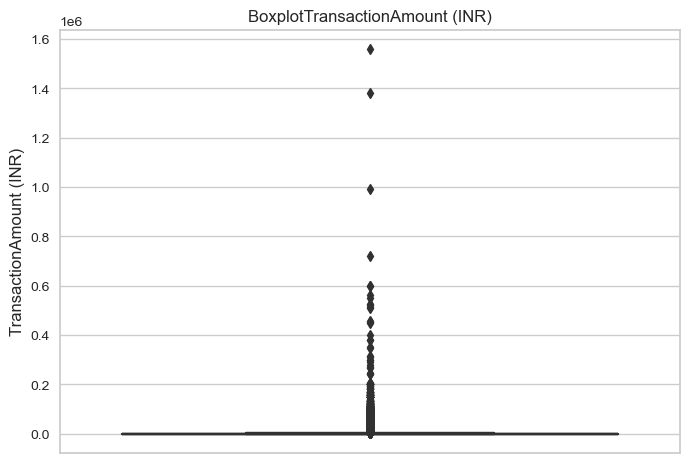

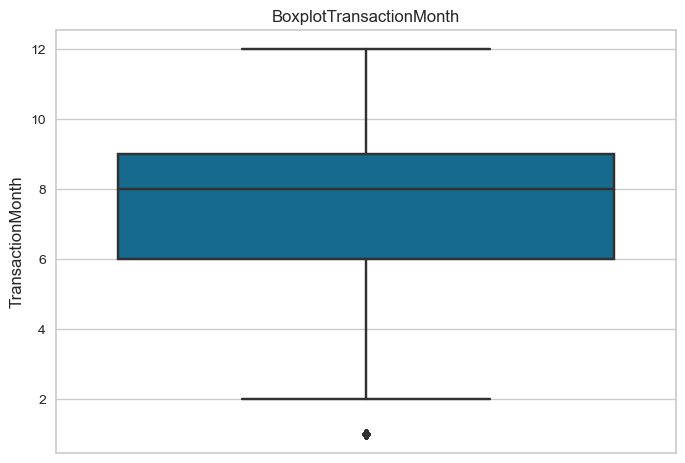

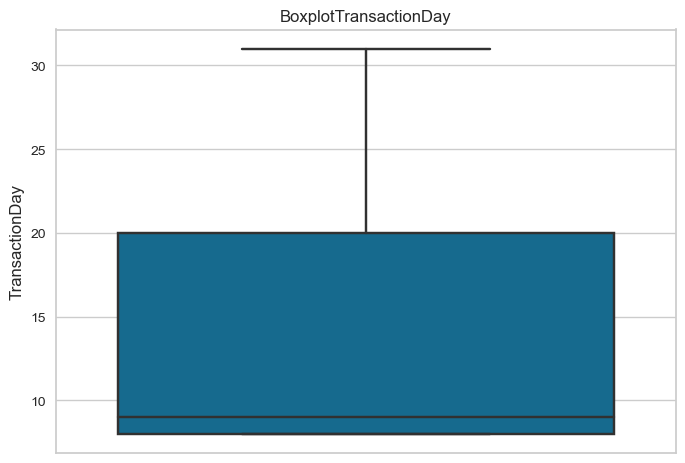

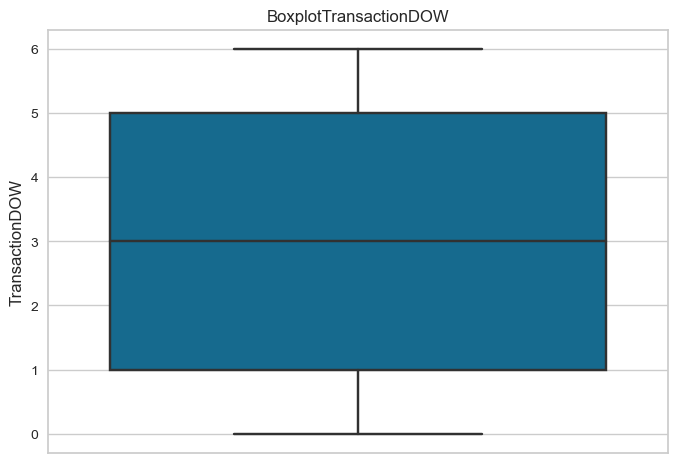

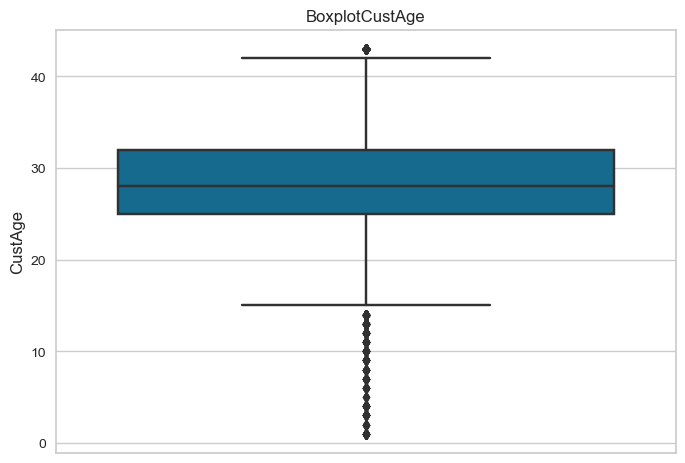

In [41]:
# Observe box plots for each feature
for i in column_names:
    sns.boxplot(y=df5[i])
    plt.title('Boxplot' + i)
    plt.show()

### Histograms

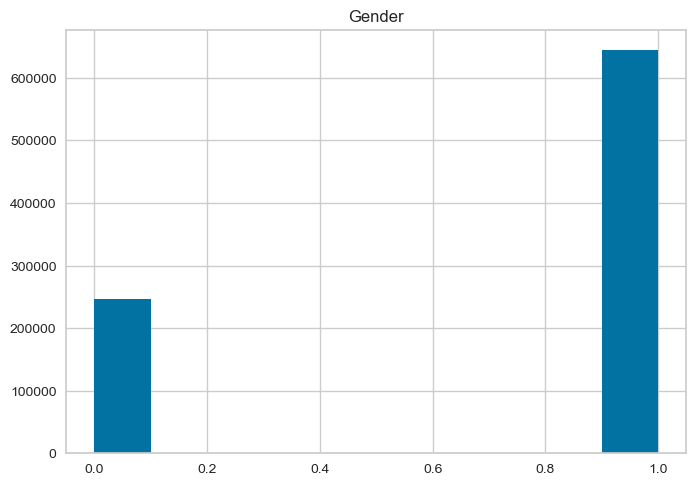

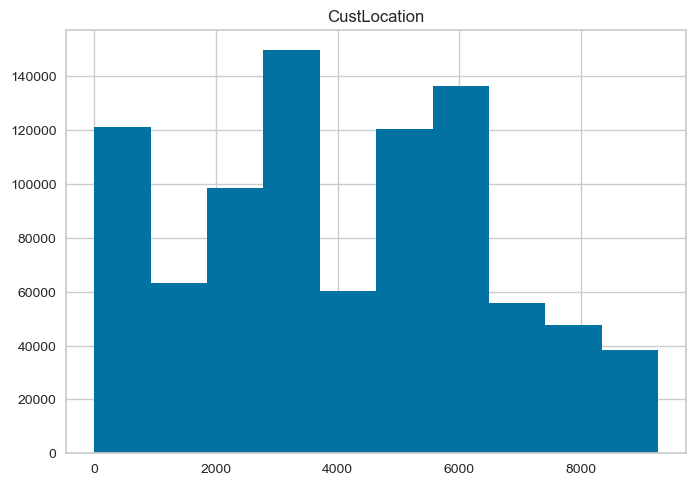

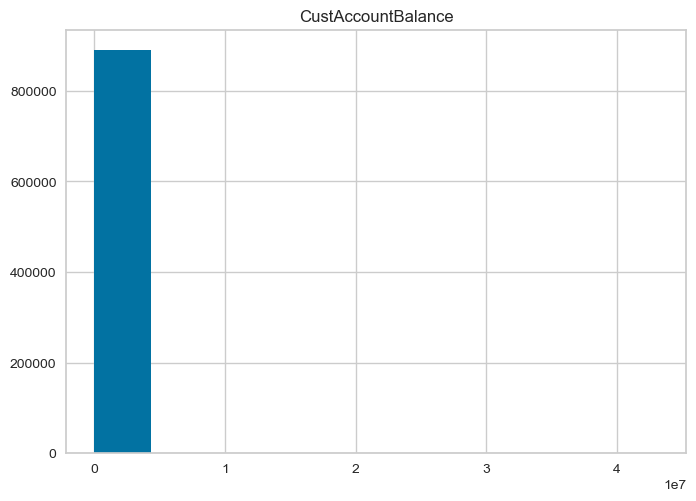

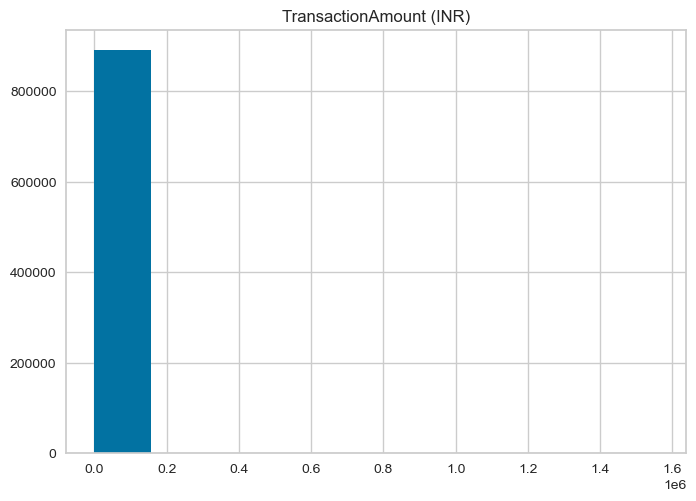

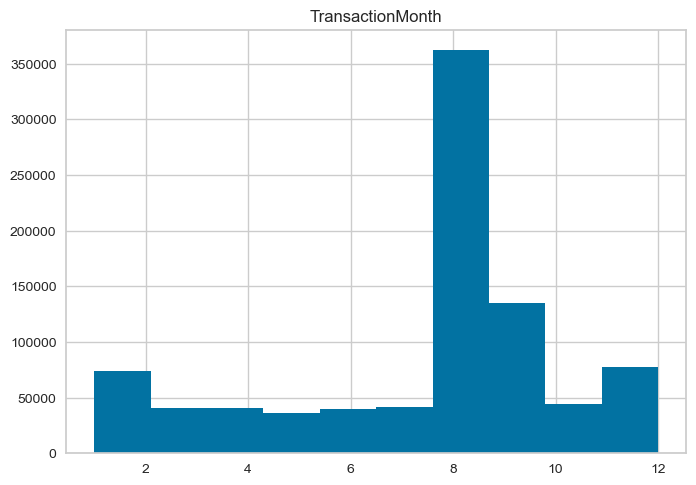

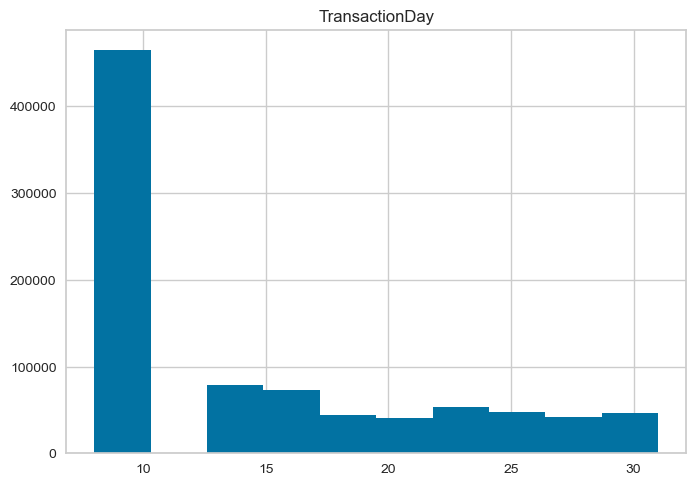

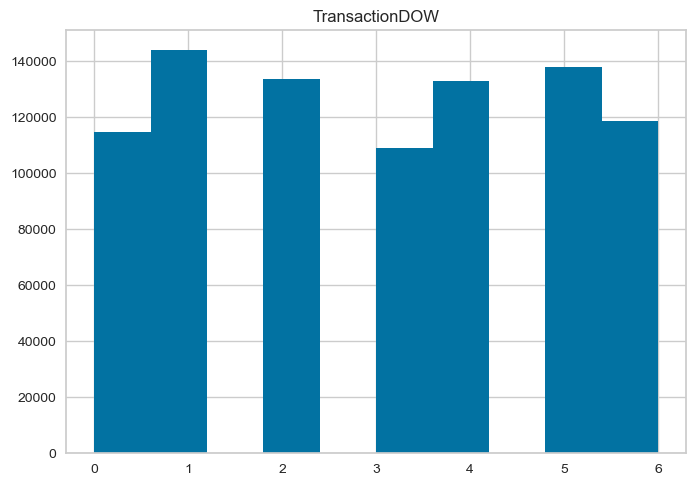

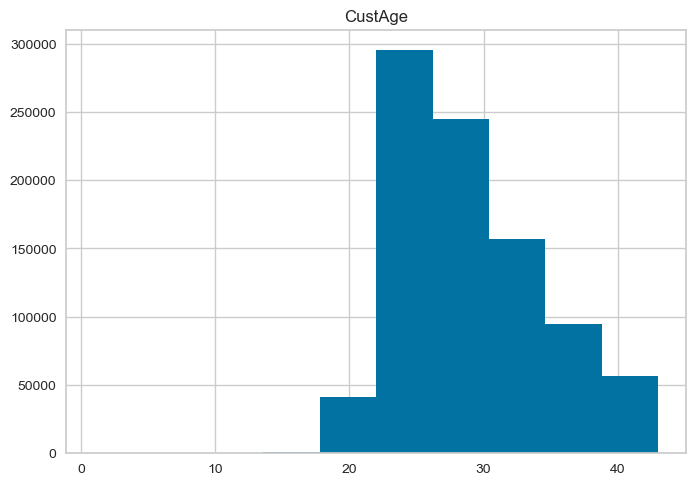

In [42]:
for i in column_names:
    plt.hist(df5[i])
    plt.title(i)
    plt.show()

# Feature Pre-Processing

In [44]:
# Scale the data with StandardScaler
s = StandardScaler()
df6 = s.fit_transform(df5)
df6 = pd.DataFrame(df6, columns=column_names)
df6.head()

,Gender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW,CustAge
0,-1.615190,-0.219659,-0.163592,-0.231829,-2.022821,-0.875939,-1.514076,-1.484369
1,-1.615190,0.481632,-0.163445,-0.151939,-2.022821,-0.875939,-1.514076,-1.857826
2,-1.615190,0.644929,-0.193113,0.088008,-2.022821,-0.875939,-1.514076,-0.177272
3,-1.615190,0.481632,-0.208375,-0.132243,-2.022821,-0.875939,-1.514076,-0.924185
4,0.619122,0.481632,0.041790,-0.209187,-2.022821,-0.875939,-1.514076,0.943098


## Multivariate analysis

### Scatter Plots

#### Day of Week vs Account Balance

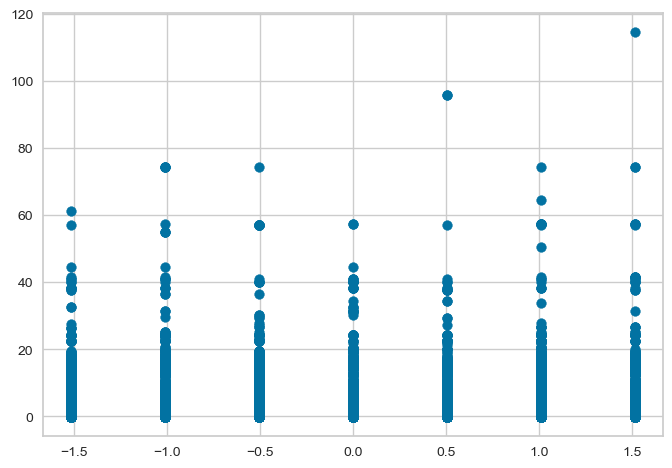

In [45]:
plt.scatter(df6['TransactionDOW'], df6['CustAccountBalance'])

#### Transaction Amount vs Account Balance

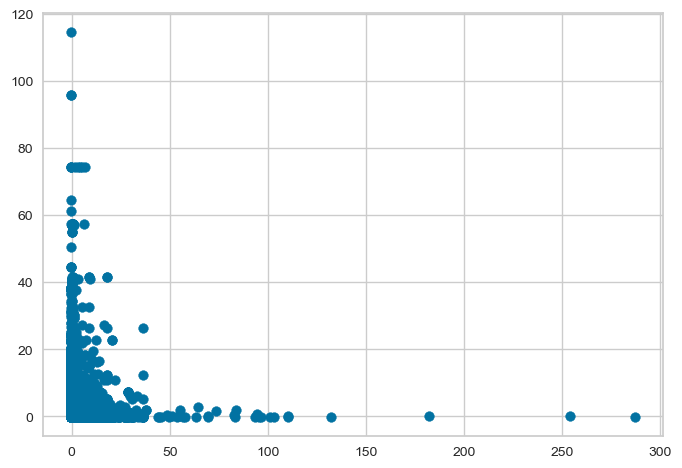

In [46]:
plt.scatter(df6['TransactionAmount (INR)'], df6['CustAccountBalance'])

#### Location vs Transaction Amount

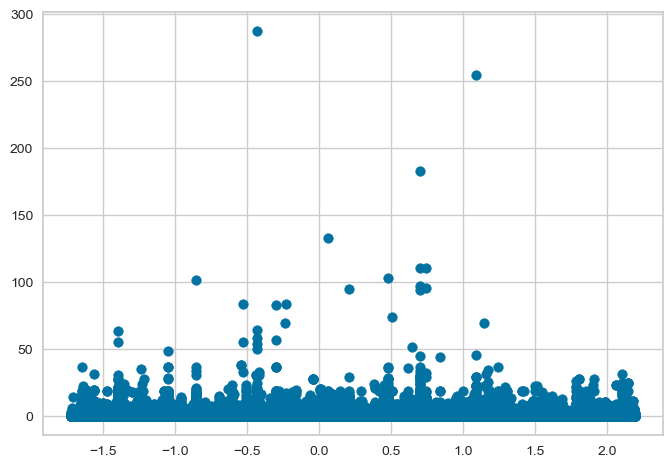

In [47]:
plt.scatter(df6['CustLocation'],df6['TransactionAmount (INR)'])

#### Location vs Transaction Amount and Account Balance

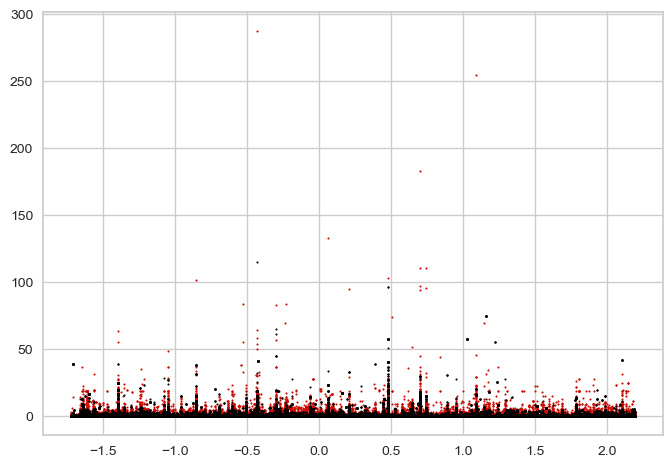

In [48]:
X = df6['CustLocation']
Y1 = df6['TransactionAmount (INR)']
Y2 = df6['CustAccountBalance']

fig, ax = plt.subplots()
ax.plot(X,Y1,'.', color='r', markersize=3)
ax.plot(X,Y2,'.', color = "black", markersize=3)
plt.show()

#### Age vs Transaction Amount

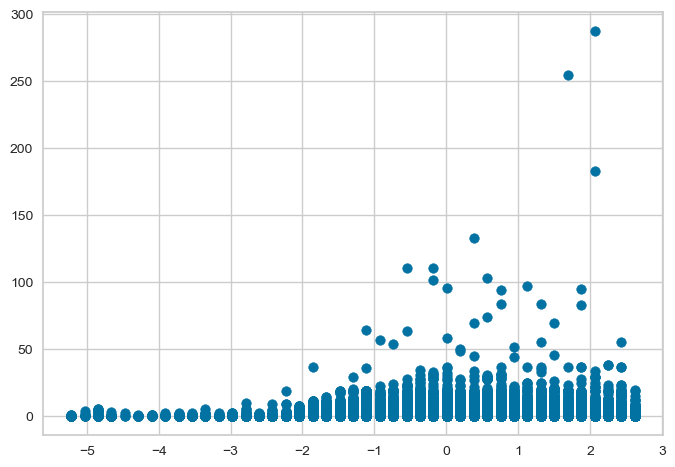

In [49]:
plt.scatter(df6['CustAge'],df6['TransactionAmount (INR)'])

# Modeling

In [82]:
# Two models. First Age & Trans Amt. Second Location & Trans Amt.
X = df6[['CustAge','TransactionAmount (INR)']].values
Y = df6[['CustLocation','TransactionAmount (INR)']].values

In [51]:
model = KMeans(init = 'k-means++', random_state = 42)

visualizer = KElbowVisualizer(model, k=(2,30), timings=False)
visualizer2 = KElbowVisualizer(model, k=(2,30), timings=False)

## Centroid-based clustering based on age

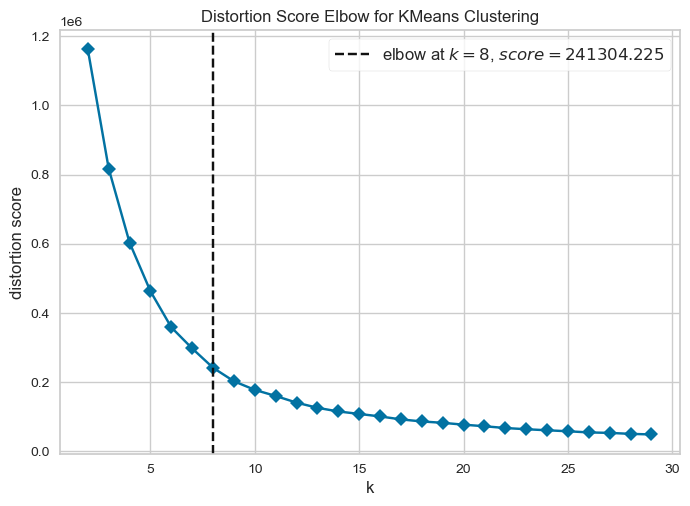

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# Elbow method for first model based on Age and Transaction Amount
visualizer.fit(X)
visualizer.show()

In [84]:
# Fit model for age and transactions
kmeans_x = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42)
x_kmeans = kmeans_x.fit_predict(X)

## Centroid-based clustering based on customer's location

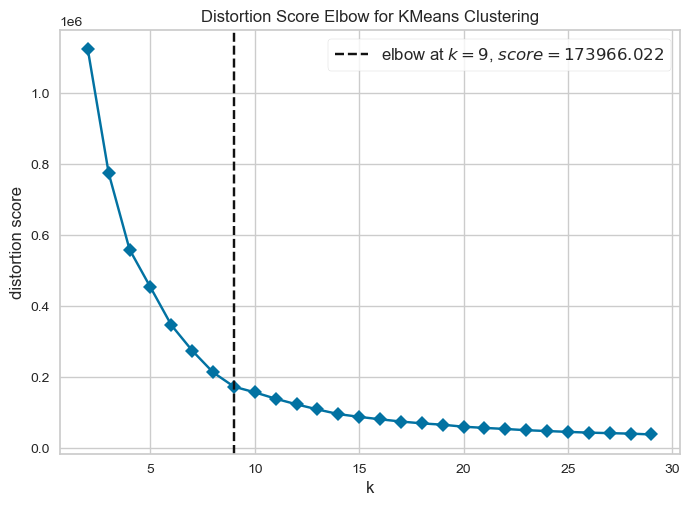

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
# Elbow method for second model based on Location and Transaction Amount
visualizer2.fit(Y)
visualizer2.show()

In [55]:
# Fit model for location and transactions
kmeans_y = KMeans(n_clusters = 9, init = 'k-means++', random_state = 42)
y_kmeans = kmeans_y.fit_predict(Y)

# Graphing the Models

In [56]:
# Get centroids of both models
centroids_x = kmeans_x.cluster_centers_
centroids_y = kmeans_y.cluster_centers_

print(centroids_x,centroids_y)

[[-2.08956084e-01 -8.27841584e-02]
 [ 7.05796794e-01 -2.42351145e-02]
 [ 3.87147841e-01  1.59978840e+01]
 [ 3.69359861e-01  4.20513722e+00]
 [-1.07954703e+00 -1.14330670e-01]
 [ 4.80011874e-01  7.81091480e+01]
 [ 1.78296657e+00  1.73682763e-02]
 [ 1.93898195e+00  2.40978323e+02]] [[-3.21027921e-01 -9.63760613e-02]
 [ 6.56767563e-01 -8.06339805e-02]
 [-1.74827874e-01  1.80942978e+01]
 [-1.19923229e+00 -9.13451339e-02]
 [ 4.52798700e-01  2.40978323e+02]
 [-7.62779362e-02  7.81091480e+01]
 [ 1.73893803e+00 -8.70411625e-02]
 [ 1.52900553e-02  6.28263989e+00]
 [-2.95331052e-02  1.96217882e+00]]


In [57]:
# Add cluster number to the dataframe
df6['cluster_age_km'] = x_kmeans
df6['cluster_location_km'] = y_kmeans
df6.head()

,Gender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW,CustAge,cluster_age_km,cluster_location_km
0,-1.615190,-0.219659,-0.163592,-0.231829,-2.022821,-0.875939,-1.514076,-1.484369,4,0
1,-1.615190,0.481632,-0.163445,-0.151939,-2.022821,-0.875939,-1.514076,-1.857826,4,1
2,-1.615190,0.644929,-0.193113,0.088008,-2.022821,-0.875939,-1.514076,-0.177272,0,1
3,-1.615190,0.481632,-0.208375,-0.132243,-2.022821,-0.875939,-1.514076,-0.924185,4,1
4,0.619122,0.481632,0.041790,-0.209187,-2.022821,-0.875939,-1.514076,0.943098,1,1


In [58]:
# Create lists of x and y coordinates of each centroid for both models
cen_xx = [i[0] for i in centroids_x] 
cen_xy = [i[1] for i in centroids_x]

cen_yx = [i[0] for i in centroids_y] 
cen_yy = [i[1] for i in centroids_y]

In [59]:
# add x and y coordinates to df
df6['cen_xx'] = df6.cluster_age_km.map({0:cen_xx[0], 1:cen_xx[1], 2:cen_xx[2],3:cen_xx[3], 4:cen_xx[4], 5:cen_xx[5],6:cen_xx[6], 7:cen_xx[7]})
df6['cen_xy'] = df6.cluster_age_km.map({0:cen_xy[0], 1:cen_xy[1], 2:cen_xy[2],3:cen_xy[3], 4:cen_xy[4], 5:cen_xy[5],6:cen_xy[6], 7:cen_xy[7]})

df6['cen_yx'] = df6.cluster_location_km.map({0:cen_yx[0], 1:cen_yx[1], 2:cen_yx[2],3:cen_yx[3], 4:cen_yx[4], 5:cen_yx[5],6:cen_yx[6], 7:cen_yx[7], 8:cen_yx[8]})
df6['cen_yy'] = df6.cluster_location_km.map({0:cen_yy[0], 1:cen_yy[1], 2:cen_yy[2],3:cen_yy[3], 4:cen_yy[4], 5:cen_yy[5],6:cen_yy[6], 7:cen_yy[7], 8:cen_yy[8]})

In [60]:
# define and map colors for each cluster to each datapoint
colors = ['red', 'yellow', 'grey', 'green','blue','orange','pink','brown', 'purple']
df6['color_age_km'] = df6.cluster_age_km.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4],5:colors[5],6:colors[6],7:colors[7]})
df6['color_location_km'] = df6.cluster_location_km.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4],5:colors[5],6:colors[6],7:colors[7], 8:colors[8]})

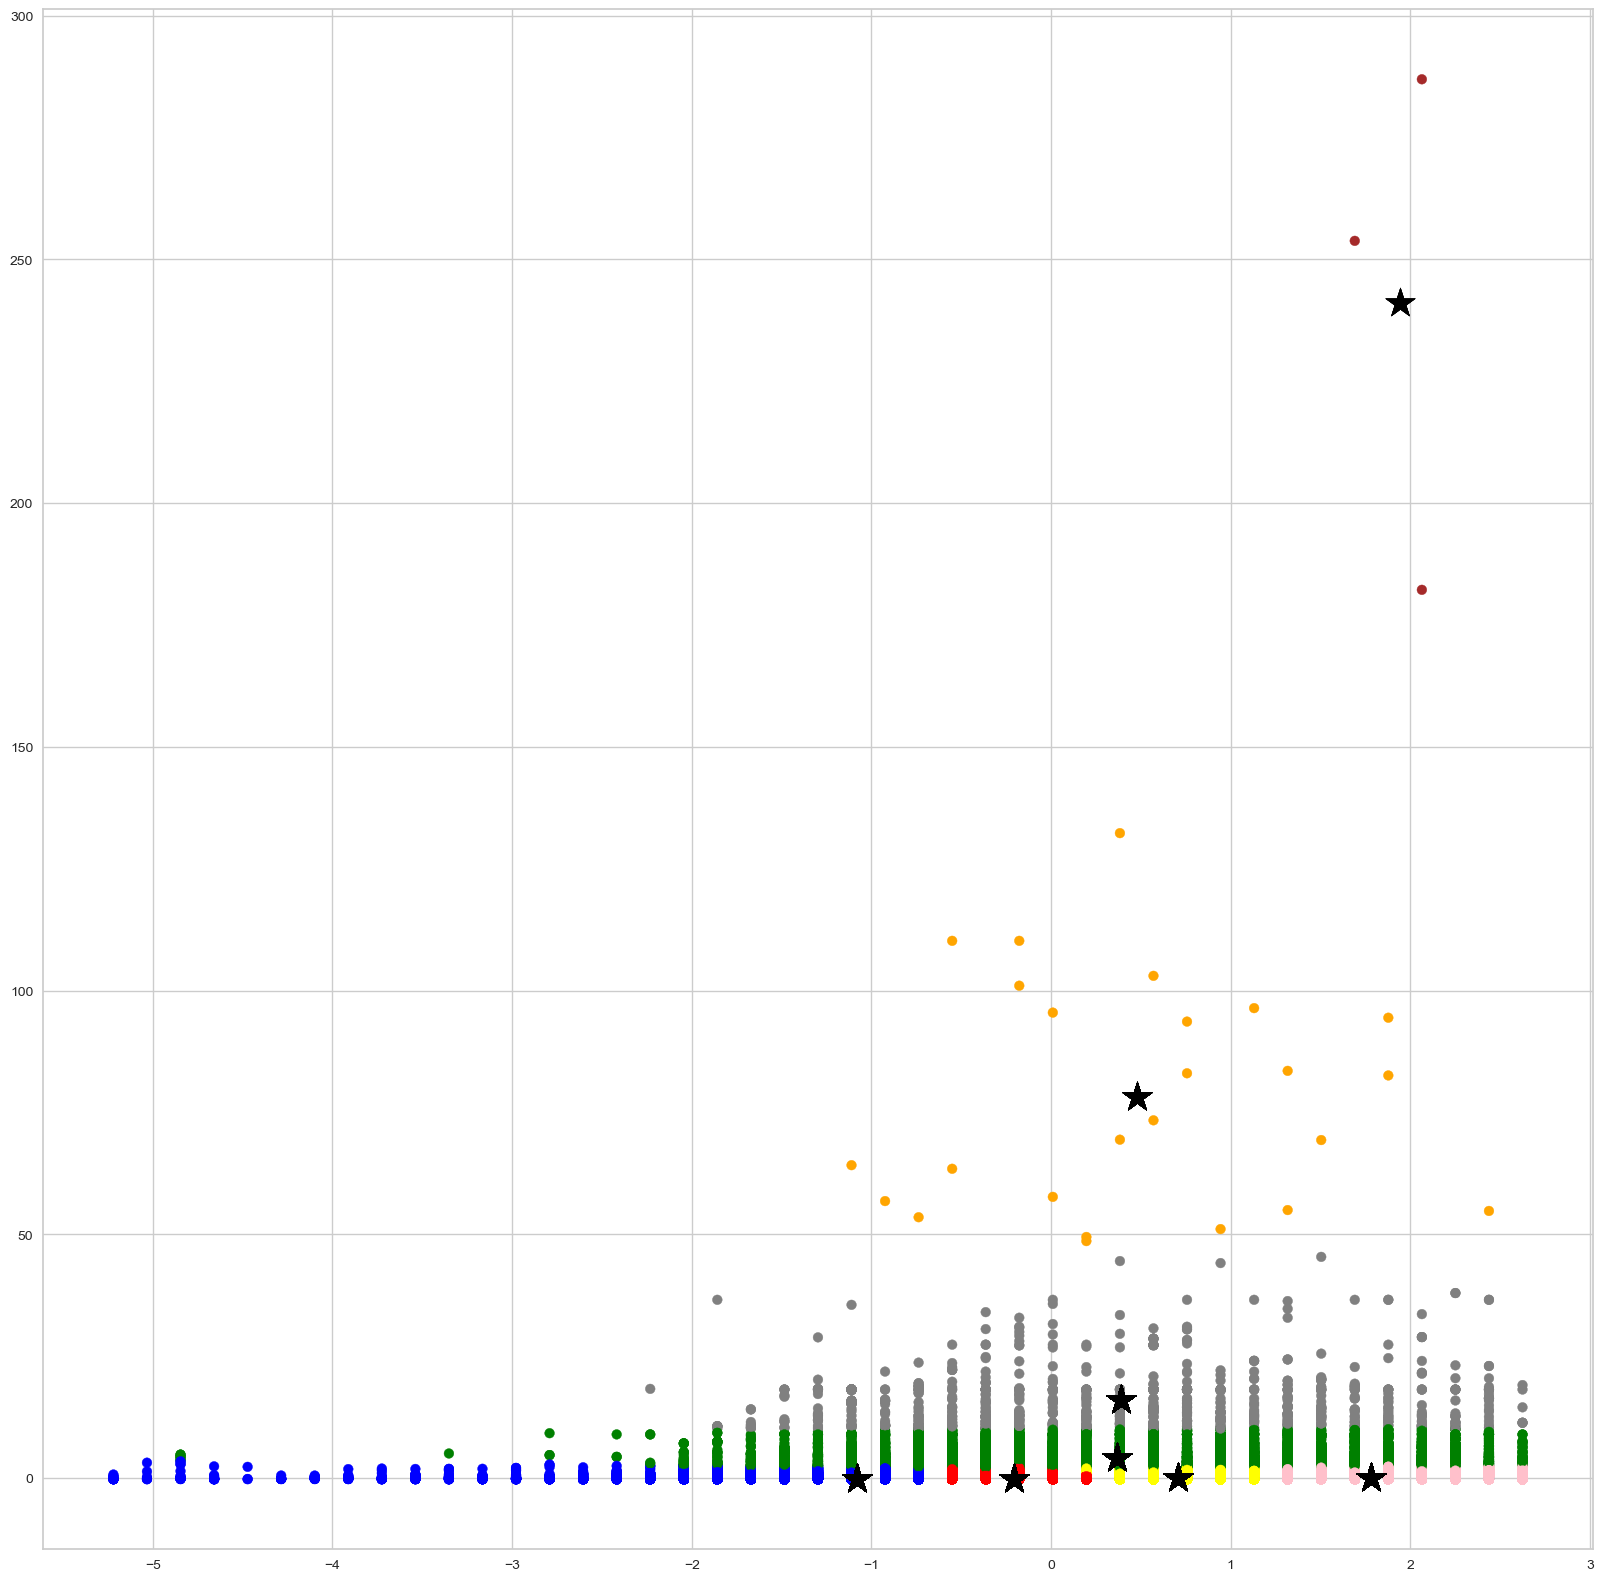

In [61]:
# Plot graph for Age Clusters
plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')
plt.scatter(df6['CustAge'], df6['TransactionAmount (INR)'], c=df6.color_age_km)
plt.scatter(df6['cen_xx'], df6['cen_xy'],marker = '*',s=500, c='black')
#plt.xlim([0, 100])
#plt.ylim([-0.5, 50])
plt.show()

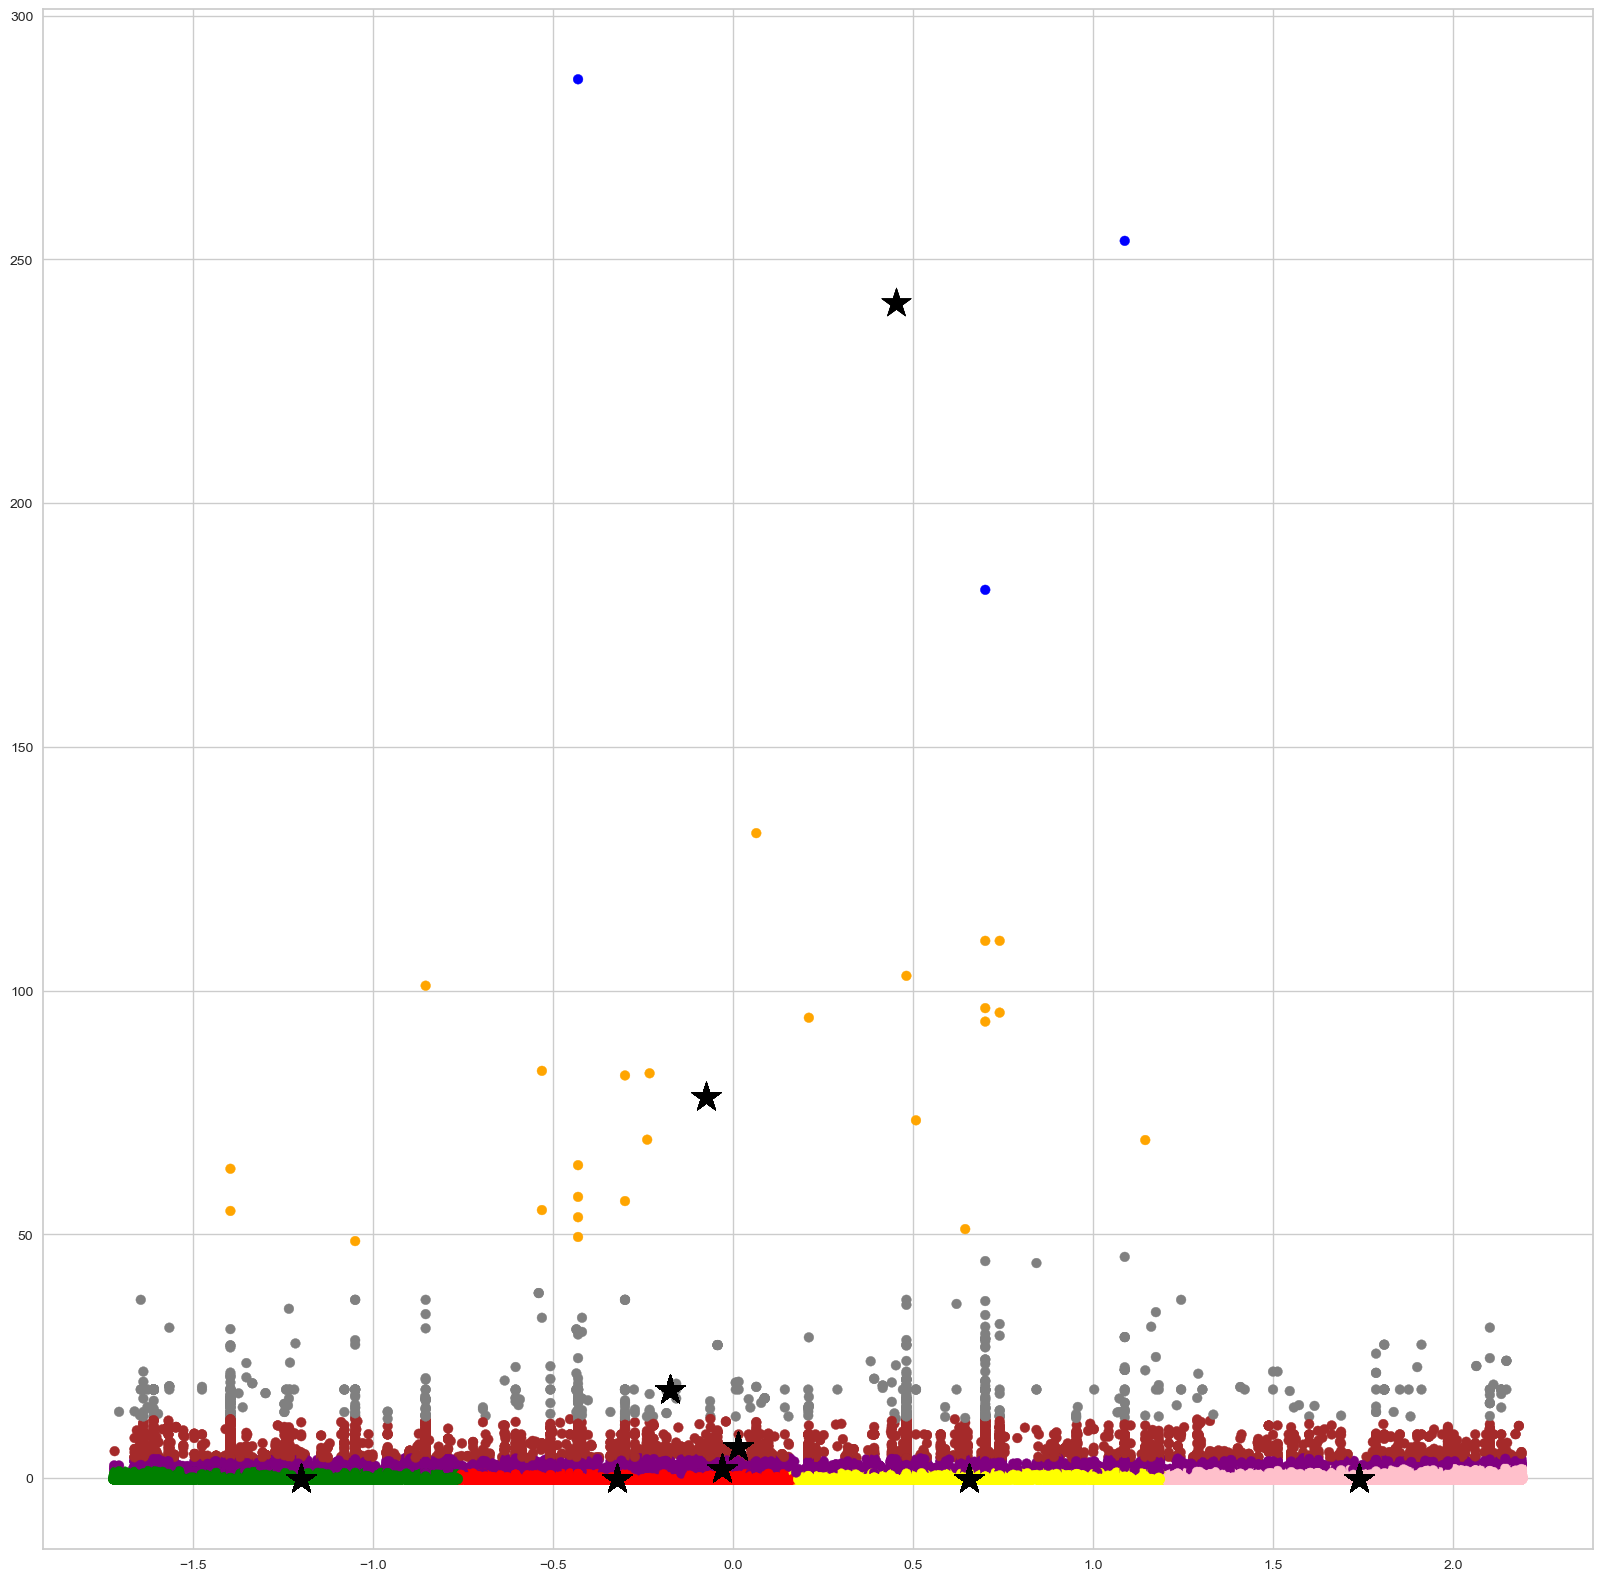

In [62]:
# Plot Graph for location clusters
plt.figure(num=None, figsize=(20, 20), facecolor='w', edgecolor='k')
plt.scatter(df6['CustLocation'], df6['TransactionAmount (INR)'], c=df6.color_location_km)
plt.scatter(df6['cen_yx'], df6['cen_yy'],marker = '*',s=500, c='black')
#plt.xlim([0, 100])
#plt.ylim([-0.5, 50])
plt.show()

# Interpret results: Extract unscaled cluster values

## Age and Transaction Amount

In [63]:
# Update unscaled df with clusters values and colors
df5['cluster_age_km'] = x_kmeans
df5['cluster_location_km'] = y_kmeans

# define and map colors
colors = ['red', 'yellow', 'grey', 'green','blue','orange','pink','brown', 'purple']
df5['color_age_km'] = df5.cluster_age_km.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4],5:colors[5],6:colors[6],7:colors[7]})
df5['color_location_km'] = df5.cluster_location_km.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4],5:colors[5],6:colors[6],7:colors[7], 8:colors[8]})

In [64]:
# View updated unscaled df
df5.head()

,Gender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW,CustAge,cluster_age_km,cluster_location_km,color_age_km,color_location_km
0,0,3557,17819.05,25.0,2,8,0,21.0,4,0,blue,red
2,0,5219,17874.44,459.0,2,8,0,19.0,4,1,blue,yellow
4,0,5606,6714.43,1762.5,2,8,0,28.0,0,1,red,yellow
6,0,5219,973.46,566.0,2,8,0,24.0,4,1,blue,yellow
7,1,5219,95075.54,148.0,2,8,0,34.0,1,1,yellow,yellow


In [65]:
# use groupby function with aggregation to get mean, min and max values based on Age and transaction amount clustering
result = df5.groupby('cluster_age_km').agg({'CustAge': ['mean', 'min', 'max'], 'TransactionAmount (INR)': ['mean', 'min', 'max']}) 
  
print("Mean, min, and max values of Age grouped by Cluster") 
print(result) 

Mean, min, and max values of Age grouped by Cluster
                  CustAge             TransactionAmount (INR)             \
                     mean   min   max                    mean        min   
cluster_age_km                                                             
0               27.830328  26.0  30.0            8.345272e+02       0.00   
1               32.729267  30.0  35.0            1.152313e+03       0.00   
2               31.022678  17.0  43.0            8.819230e+04   56340.85   
3               30.924555   3.0  43.0            2.411012e+04   12498.00   
4               23.167959   1.0  25.0            6.631628e+02       0.00   
5               31.520000  23.0  42.0            4.256094e+05  265414.00   
6               38.497829  36.0  43.0            1.378552e+03       0.00   
7               39.333333  38.0  40.0            1.310390e+06  991132.22   

                            
                       max  
cluster_age_km              
0                 12939.

## Location and Transaction Amount

In [66]:
# Create new unscaled dataframe with location names from original df
df7 = pd.merge(df5,df[['CustLocation']],left_index=True, right_index=True)

In [67]:
# View new df
df7.head()

,Gender,CustLocation_x,CustAccountBalance,TransactionAmount (INR),TransactionMonth,TransactionDay,TransactionDOW,CustAge,cluster_age_km,cluster_location_km,color_age_km,color_location_km,CustLocation_y
0,0,3557,17819.05,25.0,2,8,0,21.0,4,0,blue,red,JAMSHEDPUR
2,0,5219,17874.44,459.0,2,8,0,19.0,4,1,blue,yellow,MUMBAI
4,0,5606,6714.43,1762.5,2,8,0,28.0,0,1,red,yellow,NAVI MUMBAI
6,0,5219,973.46,566.0,2,8,0,24.0,4,1,blue,yellow,MUMBAI
7,1,5219,95075.54,148.0,2,8,0,34.0,1,1,yellow,yellow,MUMBAI


In [68]:
# use groupby function with aggregation to get mean, min and max values based on Location clustering
result_loc = df7.groupby('cluster_location_km').agg({'TransactionAmount (INR)' : ['mean', 'min', 'max']}) 
print(result_loc) 

                    TransactionAmount (INR)                       
                                       mean        min         max
cluster_location_km                                               
0                              7.610813e+02       0.00     6735.00
1                              8.467801e+02       0.00     7980.00
2                              9.958099e+04   67470.00   247832.00
3                              7.883414e+02       0.00     9530.00
4                              1.310390e+06  991132.22  1560034.99
5                              4.256094e+05  265414.00   720001.16
6                              8.115547e+02       0.00    12375.00
7                              3.542272e+04   23610.65    67291.00
8                              1.195602e+04    6132.00    23755.00


In [69]:
# convert values of each location cluster into a list 
groups = df7.groupby('cluster_location_km')['CustLocation_y'].apply(list) 
  
print(groups) 

cluster_location_km
0    [JAMSHEDPUR, GURGAON, GUNTUR, GURGAON, GURGAON...
1    [MUMBAI, NAVI MUMBAI, MUMBAI, MUMBAI, MUMBAI, ...
2    [WARANGAL, CHANDIGARH, CHANDIGARH, CHANDIGARH,...
3    [DELHI, CHENNAI, BANGALORE, CHENNAI, DHANBAD, ...
4                           [GURGAON, NEW DELHI, PUNE]
5    [GATE NO 4 MUMBAI, GATE NO 4 MUMBAI, MUNCHEN, ...
6    [THANE, SECUNDERABAD, SOCORRO, SHAHJAHANPUR, T...
7    [BURDWAN, DELHI, BHUBANESHWAR, WARANGAL, THANE...
8    [AHMEDABAD, MUMBAI, JAIPUR, MUMBAI, CHENNAI, L...
Name: CustLocation_y, dtype: object


In [70]:
# Observe count of total list
print("K=0",len(groups[0]))
print("K=1",len(groups[1]))
print("K=2",len(groups[2]))
print("K=3",len(groups[3]))
print("K=4",len(groups[4]))
print("K=5",len(groups[5]))
print("K=6",len(groups[6]))
print("K=7",len(groups[7]))
print("K=8",len(groups[8]))

K=0 214173
K=1 299938
K=2 653
K=3 253243
K=4 3
K=5 25
K=6 101236
K=7 4328
K=8 17838


In [71]:
# Calculate unique location counts of each cluster
test_list0 = list(set(groups[0]))
test_list1 = list(set(groups[1]))
test_list2 = list(set(groups[2]))
test_list3 = list(set(groups[3]))
test_list4 = list(set(groups[4]))
test_list5 = list(set(groups[5]))
test_list6 = list(set(groups[6]))
test_list7 = list(set(groups[7]))
test_list8 = list(set(groups[8]))

In [72]:
# Print Number of unique locations in each cluster
print("K=0",len(test_list0))
print("K=1",len(test_list1))
print("K=2",len(test_list2))
print("K=3",len(test_list3))
print("K=4",len(test_list4))
print("K=5",len(test_list5))
print("K=6",len(test_list6))
print("K=7",len(test_list7))
print("K=8",len(test_list8))

K=0 1789
K=1 1937
K=2 121
K=3 1858
K=4 3
K=5 16
K=6 1920
K=7 493
K=8 1326
